In [10]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

In [11]:
# read in dataset
dset = pd.read_csv('Arnar - 2016_11_9.txt',sep = ' ') # read in dataset

In [12]:
#Variables
f=10

print("Sampling rate: " + str(f) + "Hz")
print(str(dset.shape[0]) + " Data points")
print(str(dset.shape[0]/(f*60)) + " Minutes")

Sampling rate: 10Hz
45555 Data points
75.925 Minutes


In [13]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) #Picking all the data
#d = pd.DataFrame(data = dset[0:25000]) #Select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/f) # add timestamp assuming 10 samples / second

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen
#d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['belly'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
#d['bmav'] = d['belly'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
#d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
#d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
#d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]>0].values[-10:])
#d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]<0].values[-10:])
#d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
#d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
#d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
#d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
#d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

#d['brmav'] = d['brlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
#d['bfmav'] = d['bflast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
#d['brfmav'] = (d['brmav']+ d['bfmav'])/2

# movement data acceleration
d['acc'] = (d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])).apply(np.sqrt)

# movement data angular velocity
d['gyr'] = (d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])).apply(np.sqrt)

Autonomic: 19.965 minutes
Autonomic light: 41.8833333333 minutes
Normal breathing: 11.5383333333 minutes
Cardio: 1.64333333333 minutes
Total: 75.03 minutes


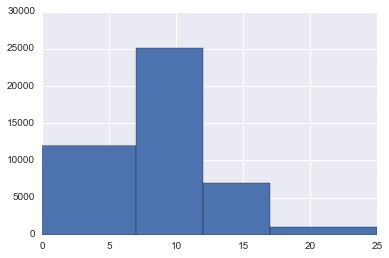

In [14]:
#Calculate the occurrence of each breathing type
occurrence=d['rfmav'].hist(bins=[0,7,12,17,25])
def get_hist(ax):
    n=[]
    for rect in ax.patches:
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        n.append(y1-y0)
    return n
n = get_hist(occurrence)

b1=n[0]/(60*f)
b2=n[1]/(60*f)
b3=n[2]/(60*f)
b4=n[3]/(60*f)

print("Autonomic: " + str(b1) + " minutes")
print("Autonomic light: " + str(b2) + " minutes")
print("Normal breathing: " + str(b3) + " minutes")
print("Cardio: " + str(b4) + " minutes")
print("Total: " + str(b1+b2+b3+b4) + " minutes")

In [15]:
f=d

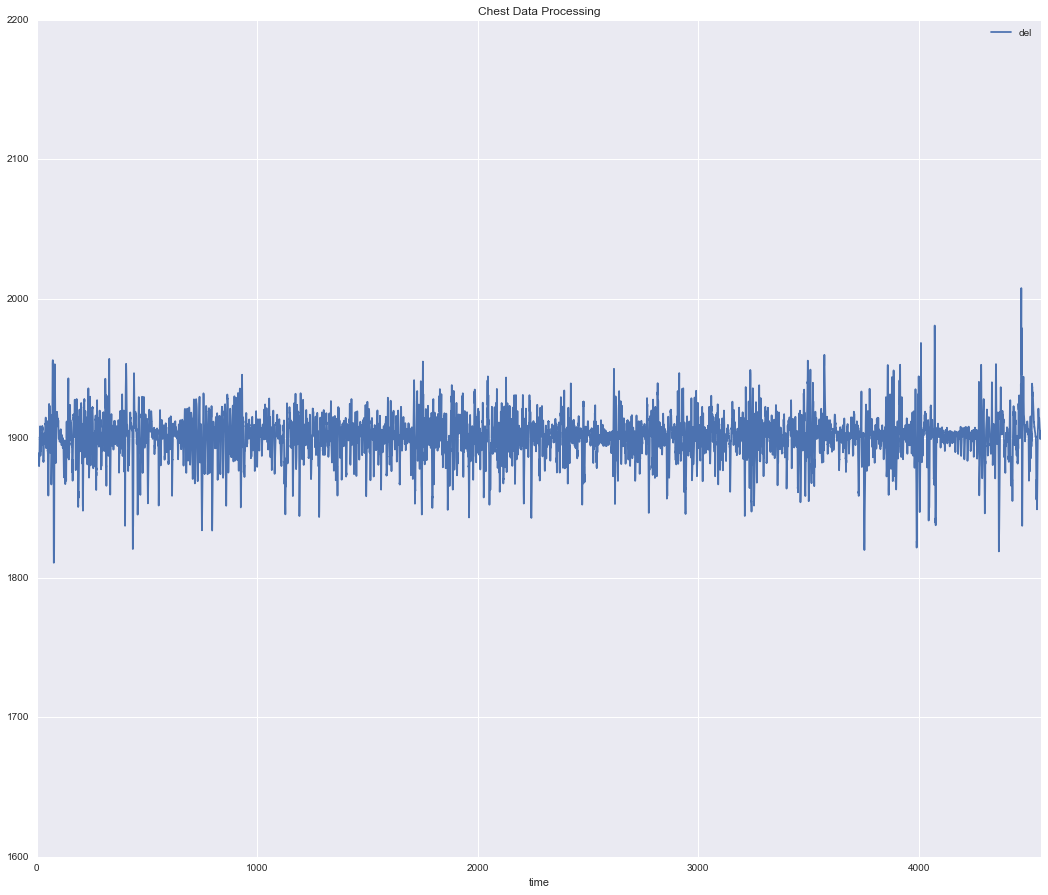

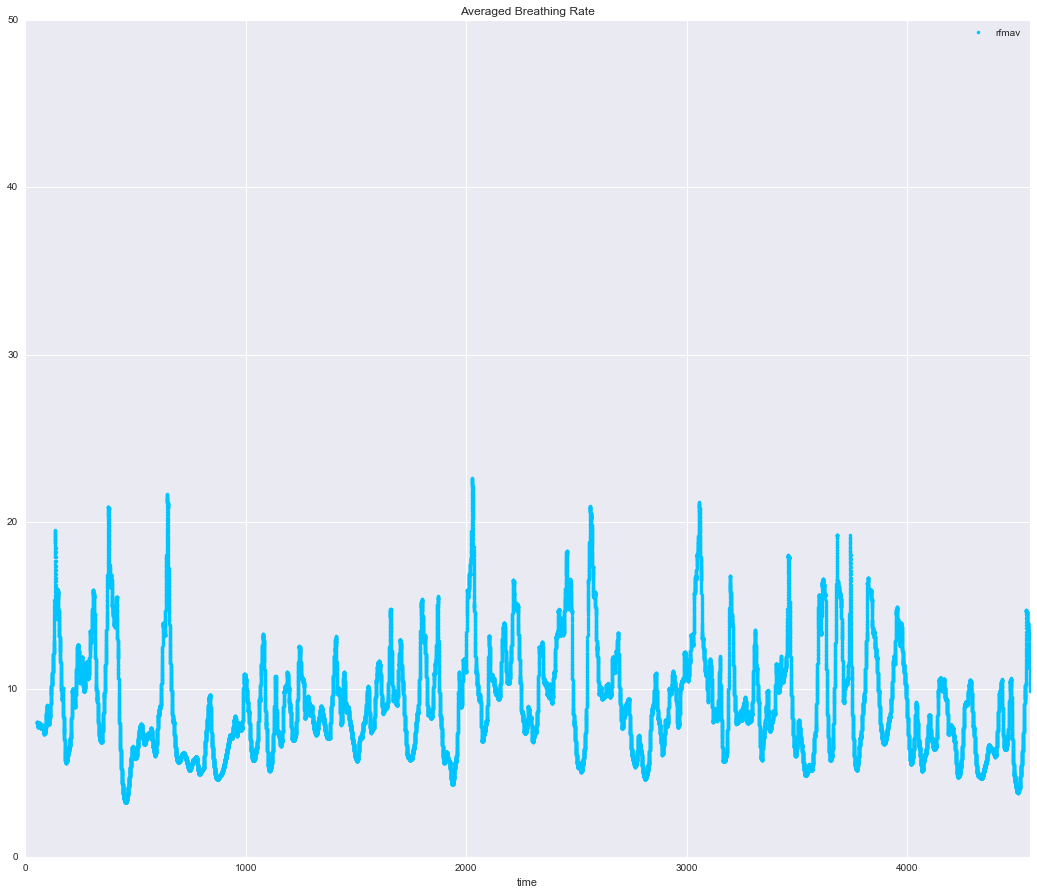

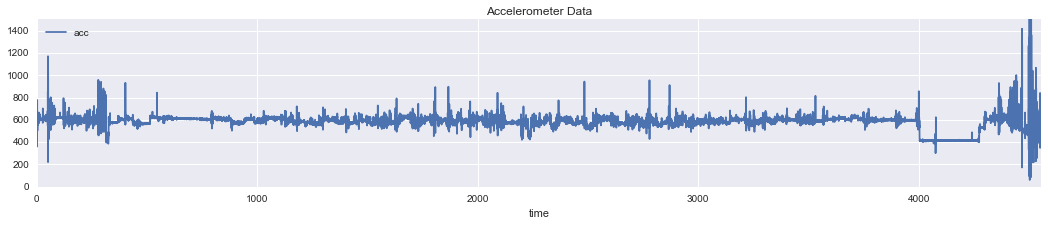

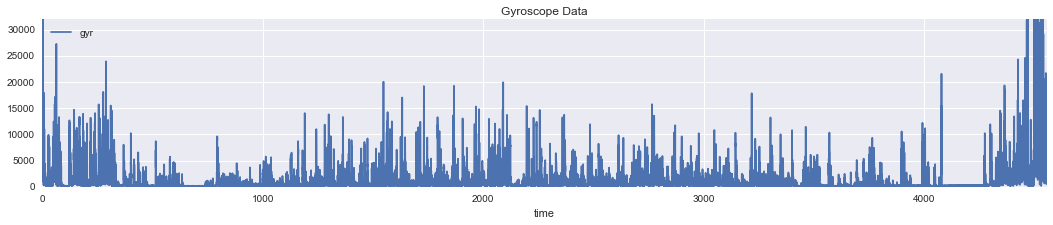

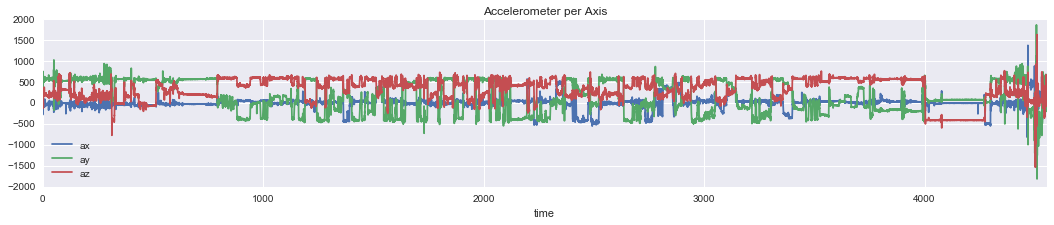

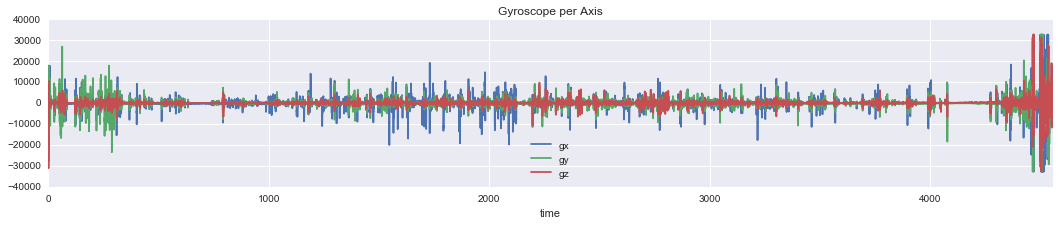

In [16]:
# this is just for plotting data 
g = d
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
#g['b2'] = 1600
#g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1600,2200), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,50), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3), ylim=(0,1500), title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3), ylim=(0,32000), title = 'Gyroscope Data')
d.plot(x = 'time',y = ['ax','ay','az'],figsize = (18,3), title = 'Accelerometer per Axis')
d.plot(x = 'time',y = ['gx','gy','gz'],figsize = (18,3), title = 'Gyroscope per Axis')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [17]:
print(d[::1000]) # every thousandth line of the processed dataset

       index  chest  belly   ax   ay   az     gx     gy     gz    time  ...   \
0          0   2771   3079  -68  624  374  -1026   4860   1140     0.0  ...    
1000    1000   2043   2238   -1  527  321   -145     67     80   100.0  ...    
2000    2000   2058   2178  -45  583   80    -74    307    693   200.0  ...    
3000    3000   2043   2208  -25  663  102   1126   1241   1211   300.0  ...    
4000    4000   2091   2214   -4  595   31   1734    250      2   400.0  ...    
5000    5000   2116   2390  -52  560  -68   -114     66     55   500.0  ...    
6000    6000   2136   2376   16  449  432   -408    229    257   600.0  ...    
7000    7000   2171   2419  -18  574  204   -137     54     85   700.0  ...    
8000    8000   2060   2259   23   39  592    763   -639   -339   800.0  ...    
9000    9000   2138   2334   51 -392  411   -403     70    150   900.0  ...    
10000  10000   2059   2324   54 -122  584   2679    568   -125  1000.0  ...    
11000  11000   2204   2513   17  175  59

In [18]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,rbtime,fbtime,rlast,flast,rmav,fmav,rfmav,acc,gyr,b1
0,0,2771,3079,-68,624,374,-1026,4860,1140,0.0,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,730.668187,5096.260982,1900
1,1,2772,3083,-112,560,199,-852,1845,-1391,0.1,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,604.768551,2462.683496,1900
2,2,2772,3081,-279,491,238,-9242,-129,-4587,0.2,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,612.834399,10318.516075,1900
3,3,2775,3083,-135,448,243,-800,-373,-619,0.3,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,527.236190,1078.095543,1900
4,4,2053,2213,-231,511,152,-5321,-1095,-263,0.4,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,581.021514,5438.863392,1900
5,5,2053,2212,-212,179,227,-5354,3139,3589,0.5,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,358.488494,7169.348506,1900
6,6,2060,2219,-200,575,224,1793,-173,9086,0.6,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,648.691760,9262.838334,1900
7,7,2068,2223,-73,508,88,6253,834,4324,0.7,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,520.708172,7648.041645,1900
8,8,2072,2225,-191,643,153,-11168,-1036,-5245,0.8,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,687.996366,12381.742406,1900
9,9,2075,2225,-125,505,120,253,8994,-2614,0.9,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,533.900740,9369.580620,1900
